In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import PIL.Image as Image
import sys
from torch.utils.data import Dataset, DataLoader
import pickle
import torchvision
from torchvision import datasets, models, transforms
import binvox_rw

# Path for the model to test with
PATH = '25'

# The threshold for the binvox creation same as for training
THRESH = 0.2

# Added to get consistent results on multiple machines
np.random.seed(0)

In [ ]:
#! cp Debug/0/model.binvox .
! ls

In [ ]:
def IoU(actual, predicted):
    return np.sum(actual*predicted)/np.sum(actual.astype(np.bool_)+predicted.astype(np.bool_))

In [ ]:
class ResNetFC(torch.nn.Module):

  def __init__(self, hidden_dim):
    
    super(ResNetFC, self).__init__()

    self.fc1 = nn.Linear(hidden_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    self.relu = nn.ReLU()

  def forward(self, input):
    
    x = self.fc1(self.relu(input))
    y = self.fc1(self.relu(x))

    return x+y

In [ ]:
class OccupancyNet(torch.nn.Module):
    def __init__(self, input_len=3, num_channels=3, num_images=4, debug=False):
        super(OccupancyNet, self).__init__()
        self.debug = debug
        self.num_channels = num_channels
        self.num_images = num_images
        self.input_len = input_len
        self.resnet18 = models.resnet18(pretrained=True)
        
        # freeze layers
        count = 1
        FREEZE_COUNT = 6
        for child in self.resnet18.children():
            count += 1
            # if count >= FREEZE_COUNT:
            #     break
            for param in child.parameters():
                param.requires_grad = False
        print(count)
        
        self.decoder_conv = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, stride=2, padding=5)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu1 = nn.ReLU()
        
        self.decoder_linear = nn.Linear(6272, 256)
        
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0)

        if self.debug:
            print(self.resnet18)
            # pick out layer
            print(self.input_len)
        self.fc1 = nn.Linear(int(self.input_len),int(256))
        self.fc2 = nn.Linear(int(256), int(256))
        self.fc3 = nn.Linear(int(256), int(256))
        self.output_layer = nn.Linear(int(256), 1)
        
        self.fc_z = nn.Linear(int(256), int(256))

        self.resnet_b = ResNetFC(int(256))

    def forward_resnet(self, input):
        # I guess this should work, not sure though
        x = self.resnet18.conv1(input)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)
        
        x = self.conv2(x)

        # need to check and change shape
        return x

    def encoder(self, images):
        y = None
        for i in range(self.num_images):
            if self.debug:
                print(images[:,self.num_channels*i:self.num_channels*(i+1),:,:].shape)
            
            if y is None:
                y = self.forward_resnet(images[:,self.num_channels*i:self.num_channels*(i+1),:,:])
            else:
                y = y.clone() + self.forward_resnet(images[:,self.num_channels*i:self.num_channels*(i+1),:,:])

        return y
    
    def decoder(self, inp):
        x = self.decoder_conv(inp)
        x = self.bn1(x)
        x = torch.flatten(x,1)
        x = self.relu1(x)
        x = self.decoder_linear(x).squeeze()
        
        return x
    
    def loss_addon(self, pt, z, img):
        
#         net_z = self.fc3(z).unsqueeze(1)
#         net = pt + net_z
        net = pt
        y = self.decoder(img)
        x = self.combiner(net, y)
        return x
    
    def combiner(self, point, y):
        x = self.fc1(point)
        x += y
        # x = self.fc2(x)
        # x += y

        x = self.resnet_b(x)
        x = self.resnet_b(x)
        x = self.resnet_b(x)
        x = self.resnet_b(x)
        x = self.resnet_b(x)

        x = self.relu1(x)
        x = self.output_layer(x)

        return x
    
    def forward(self, images, point):
        # not complete architecture
        y = self.encoder(images)
        if self.debug:
            print(y.shape)
            
        y = self.decoder(y)
        
        x = self.combiner(point, y)
        
        sig = nn.Sigmoid()
        return sig(x)

In [ ]:
model = OccupancyNet(debug=False)

11


In [ ]:
class SubSet(Dataset):
    def __init__(self,dataset,idx):
        self.ds = dataset
        self.idx = idx
    def __len__(self):
        return len(self.idx)
    def __getitem__(self,i):
        return self.ds[self.idx[i]]

In [ ]:
class ImageVoxelDataset(Dataset):
    def __init__(self, num_images=4, is_voxel=False, input_shape=(32, 32, 32), 
                 loc="./Debug1u/",
                 img_loc = "./Debug1/",
                 def_images=["000.npy", "001.npy", "002.npy", "003.npy"], debug=False):
        ## def_images=["000.jpg", "001.jpg", "002.jpg", "003.jpg"]
        self.num_images = num_images
        self.debug = debug
        self.loc = loc
        self.img_loc = img_loc
        self.is_voxel = is_voxel
        self.input_shape = input_shape
        self.input_size = np.prod(np.array(self.input_shape))
        self.objects = os.listdir(loc)
        self.num_objects = len(self.objects)
        if self.debug:
            print(self.num_objects)
        self.def_images = def_images


    def __len__(self):
        if self.is_voxel:
            return self.num_objects
        else:
            return self.num_objects * self.input_size

    def __getitem__(self, i=32):
        # return preprocessed image inputs and outputs
        # generate random point in space
        
        # most probable conversion from i to each point
        # in __init__ have a list of n objects, each pointing to a folder
        # each of the n objects will self.input_size number of points in them
        
        if not self.is_voxel:
            if self.debug:
                print("Point")
            object_num = int(i/self.input_size)
            element_num = i%self.input_size
            x_size = self.input_shape[1]*self.input_shape[2]
            x = int(element_num/x_size)
            y = int((element_num-(x*x_size))/self.input_shape[2])
            z = int(element_num-(x*x_size)-(y*self.input_shape[2]))

            point = np.array([x, y, z])
            model = None
            #with open(self.loc+self.objects[int(object_num)]+"/model.binvox", 'rb') as f:
            #    model = binvox_rw.read_as_3d_array(f)
            model = np.load(self.loc+self.objects[int(object_num)]+"/model.npy")
            multi = int(32/self.input_shape[0])
            occupied = model[multi*x, multi*y, multi*z]

            images = None

            for img_num in range(self.num_images):
                image = np.array(np.load(self.img_loc+self.objects[int(object_num)]+"/images/"+self.def_images[img_num]))
                if self.debug:
                    print(image.shape)
                if images is None:
                    images = np.zeros((image.shape[0],image.shape[1], image.shape[2]*self.num_images))

                images[:,:,img_num*image.shape[2]:(img_num+1)*image.shape[2]] = image

            images = np.transpose(images,(2,0,1))
            if self.debug:
                print("Point", point)
                print("Images", images.shape)
                print("Occupied", occupied)
            return {"obj": self.objects[int(object_num)], "obj_num": object_num, "image": images.astype(np.float32), "point":point.astype(np.float32), "occupied":occupied.astype(int)}

        else:
            #load voxel data
            if self.debug:
                print("Voxel") 
            model = None
            with open(self.loc+self.objects[int(i)]+"/model.binvox", 'rb') as f:
                model = binvox_rw.read_as_3d_array(f)
            occupied = model.data

            images = None

            for img_num in range(self.num_images):
                image = np.array(np.load(self.img_loc+self.objects[int(i)]+"/images/"+self.def_images[img_num]))
                if self.debug:
                    print(image.shape)
                if images is None:
                    images = np.zeros((image.shape[0],image.shape[1], image.shape[2]*self.num_images))

                images[:,:,img_num*image.shape[2]:(img_num+1)*image.shape[2]] = image

            images = np.transpose(images,(2,0,1))
            if self.debug:
                print("Images", images.shape)
                print("Occupied", occupied)
            return {"image":images.astype(np.float32), "occupied":occupied.astype(int)}


In [ ]:
ivd = ImageVoxelDataset(debug=False)

In [ ]:
val_percentage = .03
val_size = int(ivd.num_objects * val_percentage)
val_objects = np.random.choice(ivd.num_objects,size=val_size,replace=False)
# train_objects = np.delete(np.arange(ivd.num_objects),val_objects)
# test_objects = np.append(train_objects, val_objects)
print(len(val_objects))#, len(train_objects), len(np.unique(test_objects)))
#print(val_objects)

val_idx = None
for objs in val_objects:
    if val_idx is None:
        val_idx = np.arange(objs*ivd.input_size,(objs+1)*ivd.input_size)
    else:
        val_idx = np.append(val_idx, np.arange(objs*ivd.input_size,(objs+1)*ivd.input_size))

print(len(val_idx))#, len(train_idx), len(np.unique(test_idx)), len(ivd), len(np.unique(test_idx)) == len(ivd), len(val_idx) + len(train_idx) == len(np.unique(test_idx)))

96
3145728


In [ ]:
def model_accuracy(model, dataloader_check, batch_size, device):

  correct = 0
  total = 0
  model = model.to(device)
  with torch.no_grad():
      for data in dataloader_check:
          local_X = data["image"].float()
          local_Y = data["occupied"].float()
          local_Z = data["point"].float()
          local_X = local_X.to(device)
          local_Y = local_Y.to(device)
          local_Z = local_Z.to(device)
      
          outputs = model(local_X, local_Z)
          _, predicted = torch.max(outputs.data, 1)
          total += local_Y.size(0)
          correct += (predicted == local_Y).sum().item()

  return 100 * correct / total

In [ ]:
val_data = SubSet(ivd,val_idx)

In [ ]:
workers = 8
batch_size = 400
val_data = DataLoader(val_data,batch_size=batch_size,shuffle=False,num_workers=workers)

In [ ]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
model = model.to(device)

In [ ]:
index = 0
total = len(val_data)

points = {}
obj = []
print(len(points))
with torch.no_grad():
    for data in val_data:  
      index +=1
      objects = data["obj"]
      obj_num = data["obj_num"]
      local_X = data["image"].float()
      local_Z = data["point"].float()
      local_X = local_X.to(device)
      local_Z = local_Z.to(device)


      outputs=model(local_X, local_Z)  
      # keep track of points that here based on outputs
      point_indices = np.argwhere(np.array(outputs.squeeze().squeeze().cpu()) >= THRESH)
      #print(np.array(outputs.squeeze().squeeze().cpu()).shape)
      #print(point_indices.shape)
      print("{} of {}".format(index,total), end="\r")
      obj.append(set(objects))
      for ind in point_indices:
        #print(int(ind))
        key = str(objects[int(ind)]) #str(obj_num[ind].cpu())
        #print(key, str(obj_num[ind].cpu()))
        val = np.array(local_Z[ind].cpu())[0]
        if key in points.keys():
            #print('again')
            points[key] = np.append(points[key], np.array([val]), axis=0)
        else:
            points[key] = np.array([val])

0


In [ ]:
# for key in points.keys():
#     print(points[key])

In [ ]:
os.makedirs('./ops-data'+PATH)
for key in points.keys(): 
    #with open("./model.binvox", 'rb') as f:
        #model = binvox_rw.read_as_3d_array(f)
    vox = binvox_rw.Voxels(points[key].T, [32, 32, 32], (0, 0, 0), 0, 'xyz')
    vox_file = open('./ops-data' + str(PATH) + '/oyehoye'+key+'.binvox', 'wb')
    #arr = np.zeros((16,16,16))
    #print(points[key].shape)
    #break
    #arr[points[key][:,0], points[key][:,1], points[key][:,2]] = 1
    #model.data = arr
    #model.write(vox_file)
    vox.write(vox_file)    

In [ ]:
!zip -r ops-data25.zip ops-data25/*

In [ ]:
set_obj = []
for o in obj:
    if list(o)[0] not in set_obj:
        set_obj.append(list(o)[0])

In [ ]:
set_obj

In [ ]:
#import matplotlib.pyplot as plt
#for data in val_data:
#    plt.imshow(data['image'][0][0], cmap='gray')
#    break

In [ ]:
#fp = open('bin.binvox', 'r')
#dims, translate, scale = binvox_rw.read_header(fp)
#raw_data = np.frombuffer(fp.read(), dtype=np.uint8)

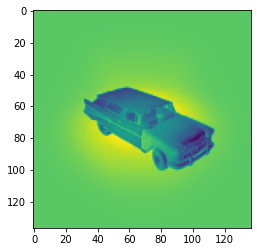

In [ ]:
from matplotlib import pyplot as plt
for data in val_data:
    img = data['image'][0][0]
    plt.imshow(img)
    break

In [ ]:
import sys
sys.version_info[0]

In [ ]:
loc="./Debug1u/"
objects = os.listdir(loc)

ious = []

for object_num in set_obj:
    model = None
    with open(loc+objects[int(object_num)]+"/model.binvox", 'rb') as f:
        model = binvox_rw.read_as_3d_array(f)
    
    predicted = points[object_num].astype(np.uint8)
    arr = np.zeros((32,32,32))
    #print(predicted.shape[0])
    arr[predicted[:,0], predicted[:,1], predicted[:,2]] = 1

#     for point in predicted:
#         print(point)
#         arr[point[0], point[1], point[2]] = 1
    ious.append(IoU(model.data, arr))

In [ ]:
print(np.mean(ious))